In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch
from tqdm import tqdm, trange

import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from pycm import ConfusionMatrix

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..')))
from src.train import Train as RobBERTTrainer
from src.textdataset import TextDataset, load_and_cache_examples

In [2]:
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robBERT-base")

INFO:transformers.tokenization_utils:Model name 'pdelobelle/robBERT-base' not found in model shortcut name list (roberta-base, roberta-large, roberta-large-mnli, distilroberta-base, roberta-base-openai-detector, roberta-large-openai-detector). Assuming 'pdelobelle/robBERT-base' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file pdelobelle/robBERT-base/added_tokens.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file pdelobelle/robBERT-base/special_tokens_map.json. We won't load it.
INFO:transformers.tokenization_utils:Didn't find file pdelobelle/robBERT-base/tokenizer_config.json. We won't load it.
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/pdelobelle/robBERT-base/vocab.json from cache at /home/pieterd/.cache/torch/transformers/dc380186a811c183c3e4c18f48dcb0ccc43b3911653369b7e5ed1b4c6d248931.6a4061e8fc00057d21d80413635a86fdcf55b6e7594ad9e252

In [3]:
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robBERT-base")
logging.info("loaded RobBERT")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/pdelobelle/robBERT-base/config.json from cache at /home/pieterd/.cache/torch/transformers/09385ae6c6a71a27f2346100bcf0141e76ca5a72ef7e0846896a07aee8ed222d.872fe2c2b52cd0be8c1ae8dd04936b8c14d0eefbe8505d0d63c4076a024ed003
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "

## Create a training config

In [4]:
from src.train_config import Config
config = Config()
config.evaluate_dataset = "../data/processed/dbrd/eval"

## Load in the data
We use `load_and_cache_examples` to load in the training data, this will produce a tokenized version with torch tensors.

For the test and evaluation sets, we'll use the following `evaluate` function, since we're in the end interested in a dataframe with all inputs and predictions.

In [5]:
def evaluate(dataset, model):
    df = pd.read_table(dataset + ".labels.txt", header=None, names=['labels'])
    df['sentence'] = pd.read_table(dataset + ".sentences.txt", header=None, names=['sentence'])
    model.eval() # disable dropout etc.
    
    mask_padding_with_zero = True
    block_size = 512
    results = []
    for row in tqdm(df.iterrows(), total=len(df), mininterval=1, position=1, leave=True):
        index = row[0]
        sentence = row[1]['sentence']
        label = row[1]['labels']

        #tokens = roberta.encode(sentence)

        tokenized_text = tokenizer.encode(tokenizer.tokenize(sentence)[- block_size + 3 : -1])

        input_mask = [1 if mask_padding_with_zero else 0] * len(tokenized_text)

        pad_token = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
        while len(tokenized_text) < block_size:
            tokenized_text.append(pad_token)
            input_mask.append(0 if mask_padding_with_zero else 1)
            #segment_ids.append(pad_token_segment_id)
            #p_mask.append(1)

        #self.examples.append([tokenizer.build_inputs_with_special_tokens(tokenized_text[0 : block_size]), [0], [0]])
        batch = tuple(torch.tensor(t).to(torch.device("cuda")) for t in [tokenized_text[0 : block_size - 3], input_mask[0 : block_size- 3], [0], [1] if label else [0]])
        inputs = {"input_ids": batch[0].unsqueeze(0), "attention_mask": batch[1].unsqueeze(0), "labels": batch[3].unsqueeze(0)}
        with torch.no_grad():
            outputs = model(**inputs)

            results.append({"true": label, "predicted": outputs[1][0].argmax().item()})

    model.train() # make sure the model is back in training mode
    return results

In [6]:
train_dataset = load_and_cache_examples("roberta", tokenizer, "../data/processed/dbrd/train")

INFO:src.textdataset:Creating features from dataset file at ../data/processed/dbrd
INFO:src.textdataset:Saving features into cached file ../data/processed/dbrd/roberta_cached_lm_512_train


In [7]:
model.train()
logging.info("Put RobBERT in training mode")

INFO:root:Put RobBERT in training mode


In [8]:
# You can use the following code to adjust the training size to experiment with the benefits of pretraining. It will not likely get better though ...
#train_dataset.examples  = train_dataset.examples[:100]

In [9]:
RobBERTTrainer.train(config, train_dataset, model, tokenizer, evaluate)

INFO:src.train:***** Running training *****
INFO:src.train:  Num examples = 19528
INFO:src.train:  Num Epochs = 2
INFO:src.train:  Instantaneous batch size per GPU = 4
INFO:src.train:  Total train batch size (w. parallel, distributed & accumulation) = 16
INFO:src.train:  Gradient Accumulation steps = 1
INFO:src.train:  Total optimization steps = 2000
Iteration:   0%|          | 0/1221 [00:00<?, ?it/s]/cw/dtaijupiter/NoCsBack/dtai/pieterd/miniconda3/envs/torch/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Iteration: 100%|██████████| 1221/1221 [12:57<00:00,  1.61it/s, learning_rate=2.23e-5, loss=0.0101, step=1221] 

Iteration:  64%|██████▍   | 779/1221 [08:52<04:58,  1.48it/s, learning_rate=0, loss=0.197, step=2001]        



(2001, 0.227121128447015)

## Evaluate our trained model

In [10]:
model.eval()
logging.info("putting model in eval mode")

INFO:root:putting model in eval mode


In [11]:
results = pd.DataFrame(evaluate("../data/processed/dbrd/test", model))


100%|██████████| 2224/2224 [00:54<00:00, 41.06it/s]

In [12]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, aspect="equal")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(len(tick_marks) - 0.5, -0.5)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1030   82]
 [  57 1055]]


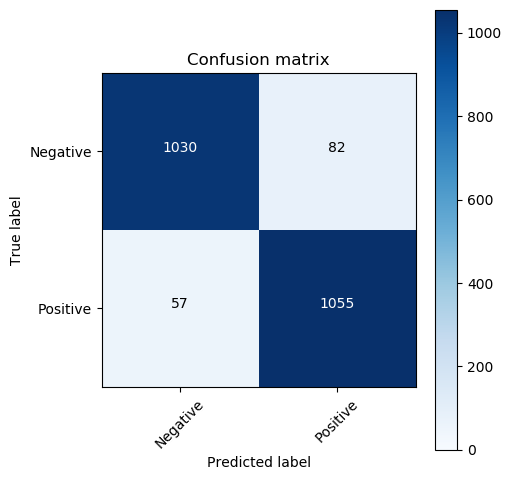

In [13]:
cnf_matrix = confusion_matrix(results['true'], results['predicted'] ) # index to evaluate partial runs

np.set_printoptions(precision=2)

title="Confusion matrix"

# Plot normalized confusion matrix
fig = plt.figure(figsize=(5,5), dpi=100)
#fig.set_size_inches(6,6)

plot_confusion_matrix(cnf_matrix, classes=["Negative", "Positive"],normalize=False, 
                      title=title, cmap=plt.cm.Blues)


In [14]:
cm = ConfusionMatrix(actual_vector=results['true'].values, predict_vector=results['predicted'].values )

In [15]:
cm.stat()

Overall Statistics : 

95% CI                                                            (0.92744,0.94756)
ACC Macro                                                         0.9375
AUNP                                                              0.9375
AUNU                                                              0.9375
Bennett S                                                         0.875
CBA                                                               0.92707
CSI                                                               0.87522
Chi-Squared                                                       1703.61107
Chi-Squared DF                                                    1
Conditional Entropy                                               0.33573
Cramer V                                                          0.87522
Cross Entropy                                                     1.00036
F1 Macro                                                          0.93749
F1 Micro     

## Saving the model

In [ ]:
from transformers import WEIGHTS_NAME, CONFIG_NAME

output_dir = "./dbrd/"

# Step 1: Save a model, configuration and vocabulary that you have fine-tuned

# If we have a distributed model, save only the encapsulated model
# (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
model_to_save = model.module if hasattr(model, 'module') else model

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_dir)